In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import math
import scipy
import emcee
import corner
import lalsimulation as ls
import h5py
import snr_calculation as s 
import populations as p
from scipy.stats import truncnorm
import processing
%load_ext autoreload
%autoreload 2

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure titledef 

In [3]:
def get_quantiles(fname, index, quantiles, hist=False, folder='mTOV_convergence', columns=None):
    root = '/mnt/c/users/christine/gwcosmology/spin_results/' + folder
    # print(root)
    array = np.genfromtxt(root+fname)
    
    if columns is not None:
        array[:,0] = array[:, columns[0]] - array[:, columns[1]]
        index = 0
    array = array[:,index]
    if hist:
        plt.hist(array,bins=50)
    return np.quantile(array, quantiles)

def plot_constraints(constraints, counts, color='b'):
    # plt.fill_between(counts, constraints[:,0], constraints[:,6], color='b', alpha=0.1, label = '$3\sigma$')
    plt.fill_between(counts, constraints[:,1], constraints[:,5], color=color, alpha=0.2, label = '$2\sigma$')
    plt.fill_between(counts, constraints[:,2], constraints[:,4], color=color, alpha=0.3, label = '$1\sigma$')
    plt.plot(counts, constraints[:,3], c='k')
    plt.scatter(counts, constraints[:,3], c='k', s=30)
    plt.legend()

In [4]:
def quantiles_from_data(array, quantiles, hist=False):    
    if hist:
        plt.hist(array,bins=50)
    return np.quantile(array, quantiles)

def get_constraints(data, name, folder='real_data'):
    constraints = np.zeros(7)
    sigma_1 = quantiles_from_data(data, [0.159, 0.841])
    sigma_2 = quantiles_from_data(data, [0.025, 0.975])
    sigma_3 = quantiles_from_data(data, [0.0015, 0.997])
    
    med = quantiles_from_data(data, [0.5])
    
    constraints = [sigma_3[0], sigma_2[0], sigma_1[0], med[0], sigma_1[1], sigma_2[1], sigma_3[1]]
    
    print('../spin_results/outputs/{}/{}'.format(folder, name))
    np.savetxt('../spin_results/outputs/{}/{}'.format(folder, name), constraints)
    return constraints

Code to make trace plots from real data

1c_default_chieff_withgw190814_withgw190426_


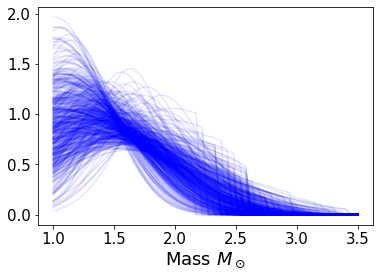

In [18]:
base='real_data'
import os
folder = '../spin_results/{}/'.format(base)
for i in ['1c_default_chieff_withgw190814_withgw190426_.txt']:
    if 'likes' not in i and os.path.isfile(os.path.join(folder, i))  and 'slope' not in i:
        root = i.split('.txt')[0]
        print(root)
        real = np.genfromtxt(folder + '{}.txt'.format(root))
        likes = np.genfromtxt(folder + '{}_likes.txt'.format(root))
        indices = np.arange(real.shape[0])
        
        if '2c' in root:
            # don't do anything
            print(i)
                
            
        elif '1c' in root:
            cutoff = np.zeros(500)
            for j in range(500):
                point = int(np.random.choice(indices, 1))
                point = real[point]
                x = np.linspace(1, 3.5)
                plt.plot(x, truncnorm.pdf(x, loc=point[0], scale=point[1], a=(1-point[0])/point[1], b=(point[2]-point[0])/point[1]), c='b', alpha=0.1)
            
        elif 'u' in root:
            cutoff = np.zeros(500)
            for j in range(500):
                point = int(np.random.choice(indices, 1))
                point = real[point]
                cutoff[j] = (point[2]-1)*0.99 + 1
                x = np.linspace(1,3.5)
                plt.plot(x, np.ones(50)/(point[2]-1), c='b', alpha=0.1)
        plt.xlabel('Mass $M_\odot$')

Code demonstrating constraint calculation (DEFUNCT)

In [217]:
real = np.genfromtxt('../spin_results/LMG_convergence/Design_mTOV_2.0_bhmin_2.0_20_u.txt')
likes = np.genfromtxt('../spin_results/LMG_convergence/Design_mTOV_2.0_bhmin_2.0_20_u_likes.txt')

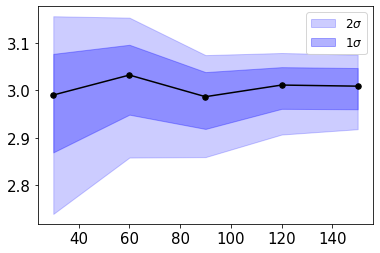

In [206]:
constraints = get_constraints_lmg_2c(np.linspace(30,150,5,dtype='int16'), 2.0, 5.0)
plot_constraints(-1*constraints,np.linspace(30,150,5,dtype='int16'),)

Code for checking for bias

In [22]:
test = p.Population([0.63, 1.35, 0.07, 1.85, 0.35, 2, 1, 3, 3, 2, 0.5], 'nsbh', vary_slope=False, selection=True, m1_nospin = True, spinning=True, spin_params=[1.0, 0.0], ignore_spin=False, verbose=False)

In [23]:
pop = test.get_population(10, False, N_samples = 500)

In [24]:
p.set_detector('O3')

In [25]:
test.set_injection_spins(p.injection_set)

In [265]:
test.selection_norm([0.63, 1.35, 0.07, 1.85, 0.35, 2, 5, 2, 1, 0])

0.8619311872251773

/mnt/c/users/christine/gwcosmology/spin!!/populations.py:1231: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(p_m1*p_m2*p_q*spin_likes/(mu)))


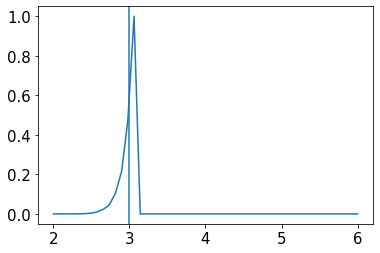

In [27]:
test.samples = False
result = np.zeros(50)
slopes = np.linspace(2.0, 6.0)
for i in range(50):
    result[i] = test.pop_like(pop, [0.63, 1.35, 0.07, 1.85, 0.35, 2, slopes[i], 2, 1, 0])
plt.plot(slopes, np.exp(result-np.max(result)))
plt.axvline(3.0)

Processing code for LMG

In [28]:
import processing

In [ ]:
processing.processing('LMG_convergence_medspin', mode='LMG_txt', plot=True)

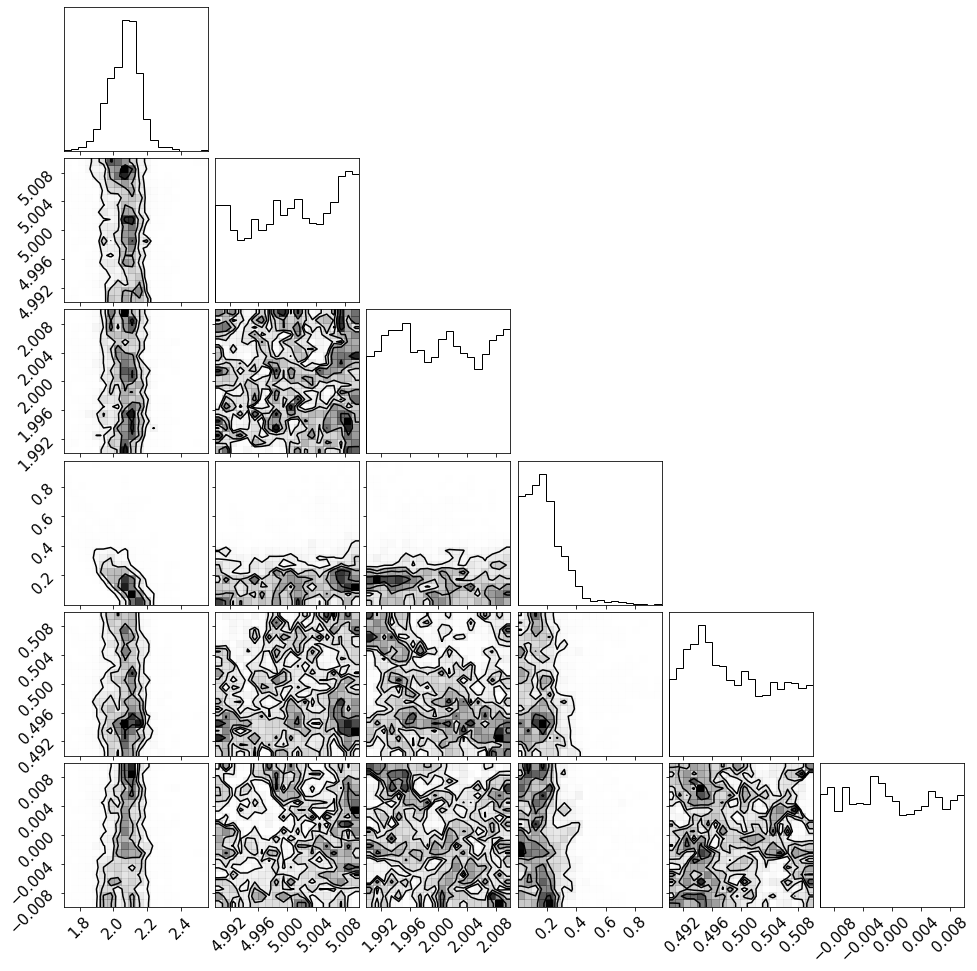

In [41]:
corner.corner(np.genfromtxt('../spin_results/medspin/Design_mTOV_2.0_run_10_2c_slope_0.2.txt')[:, 5:], plot_datapoints=False);

In [47]:
processing.table_realdata()

1c_default_chieff_nogw190814_nogw190426_.txt
1c_default_chieff_nogw190814_nogw190426_0q.txt
1c_default_chieff_nogw190814_withgw190426_.txt
1c_default_chieff_nogw190814_withgw190426_0q.txt
1c_default_chieff_withgw190814_nogw190426_.txt
1c_default_chieff_withgw190814_nogw190426_0q.txt
1c_default_chieff_withgw190814_withgw190426_.txt
1c_default_chieff_withgw190814_withgw190426_0q.txt
1c_default_direct_nogw190814_nogw190426_.txt
1c_default_direct_nogw190814_nogw190426_0q.txt
1c_default_direct_nogw190814_withgw190426_.txt
1c_default_direct_nogw190814_withgw190426_0q.txt
1c_default_direct_withgw190814_nogw190426_.txt
1c_default_direct_withgw190814_nogw190426_0q.txt
1c_default_direct_withgw190814_withgw190426_.txt
1c_default_direct_withgw190814_withgw190426_0q.txt
1c_default_pos_chieff_nogw190814_nogw190426_.txt
1c_default_pos_chieff_nogw190814_nogw190426_0q.txt
1c_default_pos_chieff_nogw190814_withgw190426_.txt
1c_default_pos_chieff_nogw190814_withgw190426_0q.txt
1c_default_pos_chieff_withgw

Processing real data

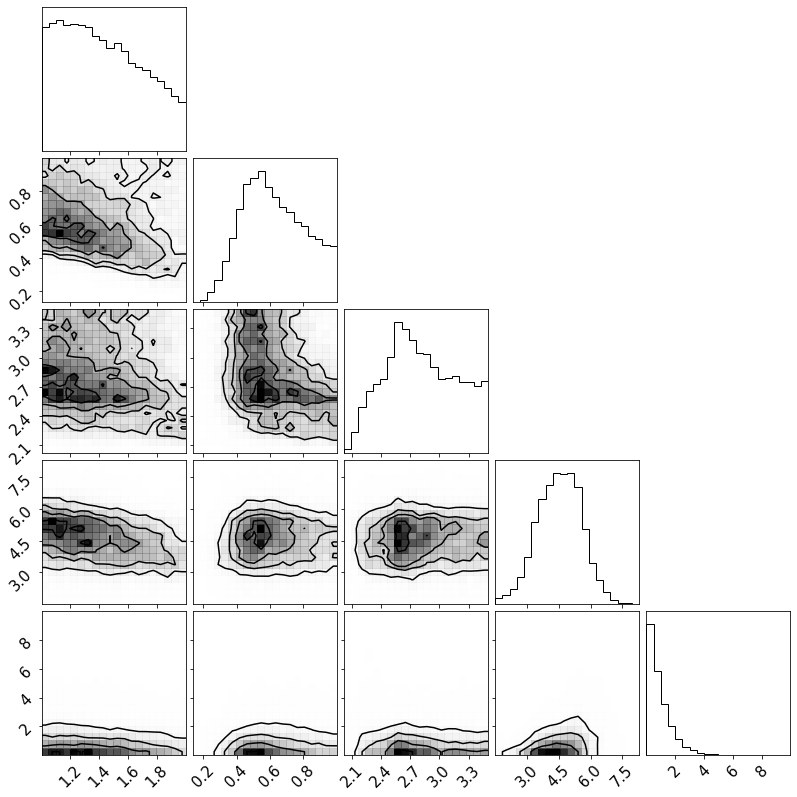

In [54]:
root='1c_default_direct_withgw190814_withgw190426_'
real = np.genfromtxt('../spin_results/real_data/{}.txt'.format(root))
likes = np.genfromtxt('../spin_results/real_data/{}_likes.txt'.format(root))
corner.corner(real[real[:,5]<=1][:, :5], plot_datapoints=False); 


../spin_results/outputs/real_data/massgap/1c_default_direct_withgw190814_withgw190426_.txt


[-1.4821941723431018,
 -0.4481084672664078,
 0.6369845090144644,
 1.745087367137498,
 2.782510122136771,
 3.7404951283298344,
 4.464819839170761]

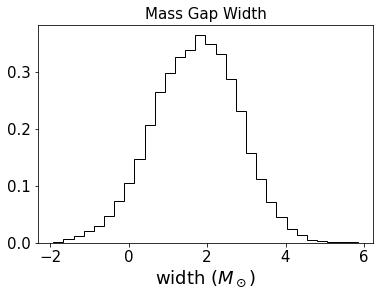

In [55]:
massgap = real[real[:,5]<=1][:,3]-real[real[:,5]<=1][:,2]
hist = plt.hist(massgap, histtype='step', color='k', density=True, bins=30)
plt.title('Mass Gap Width')
plt.xlabel('width ($M_\odot$)')
get_constraints(massgap, 'massgap/{}.txt'.format(root))

In [56]:
real = real[:,[2,3]]

In [57]:
likes = likes[np.argsort(real[:,0])]
real = real[np.argsort(real[:,0])]

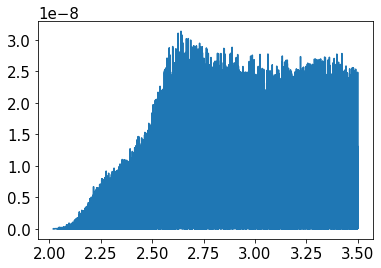

In [59]:
plt.plot(real[:, 0], np.exp(likes))

In [139]:
samples = np.genfromtxt('/mnt/c/users/christine/gwcosmology/spin_results/mTOV_convergence/mTOV_2_run_50_2component.txt')
likes = np.genfromtxt('/mnt/c/users/christine/gwcosmology/spin_results/mTOV_convergence/mTOV_2_run_50_2component_likes.txt')

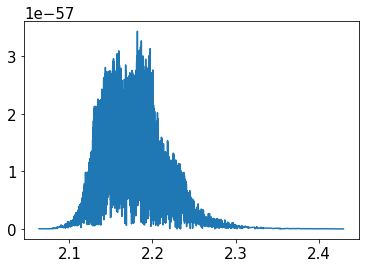

In [140]:
plt.plot(samples[:,5][np.argsort(samples[:,5])], np.exp(likes[np.argsort(samples[:,5])]))

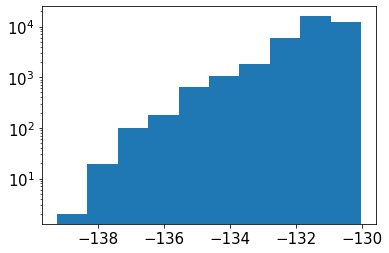

In [138]:
plt.hist(likes)
plt.yscale('log')

Inspecting individual events' posteriors

In [404]:
pop = np.genfromtxt('./results/pop_samples.txt')

In [414]:
test.samples=True

In [406]:
pop = pop.reshape((50, 3000, 4))

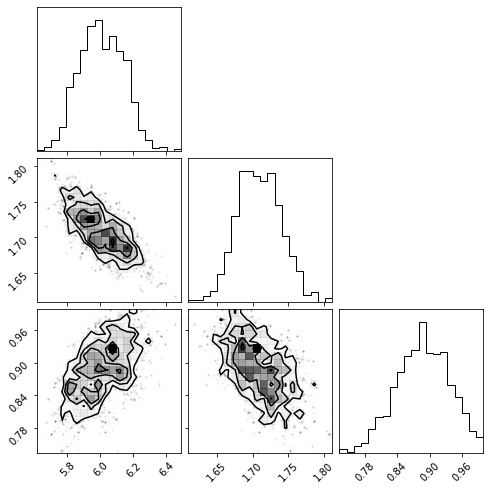

In [411]:
corner.corner(pop[30][:,[0,1,3]]);

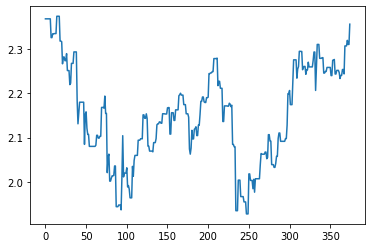

In [111]:
plt.plot(pop[1][::8,1]) # trace plot

More testing for bias

In [19]:
test = p.Population([1.4, 0.5, 2, 1, 3, 5, 4], 'nsbh_one', False, selection=True, m1_nospin = True, spinning=False, spin_params=[1, 1])

vary slope: False
selection: True
spinning: False
no m1 spin: True


In [22]:
pop = test.get_population(20, False)

0.046620046620046623


In [13]:
test.samples = True
test.pop_like(pop, [1.4, 0.5, 2, 5, 4])

-76.63955081476718

/mnt/c/users/christine/gwcosmology/spin!!/populations.py:1131: RuntimeWarning: divide by zero encountered in log
  


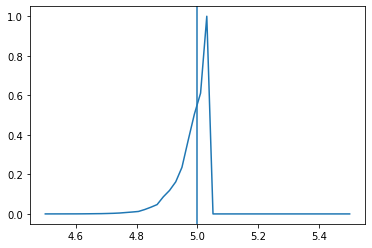

In [28]:
test.set_injection_spins(p.injection_set)
result = np.zeros(50)
slopes = np.linspace(4.5, 5.5)
#slopes = np.linspace(0.1, 1)
for i in range(50):
    result[i] = test.pop_like(pop, [1.4,  0.5,  2,slopes[i], 4])
plt.plot(slopes, np.exp(result-np.max(result)))
plt.axvline(5)

OLD AND USELESS CODE

In [413]:
test = p.Population([1.4, 0.5, 2, 1, 3, 5, 4], 'nsbh_one', False, selection=True, m1_nospin = True, spinning=True, spin_params=[1, 0])

vary slope: False
selection: True
spinning: True
no m1 spin: True


In [321]:
test = p.Population([1.4, 0.5, 2, 0, 3], 'one', False, selection=False, m1_nospin = True, spinning=False)

vary slope: False
selection: False
spinning: False
no m1 spin: True


In [310]:
pop = test.get_population(10000, False)

1.0


In [369]:
data = p.generate_truncnormal(10000,1.4, 0.5, 1, 2)

In [311]:
data = pop[:,:,0].squeeze()

In [380]:
pop = test.get_population(1000, False)
data = pop[:,:,0].squeeze()
data2 = pop[:,:,1].squeeze()
mus = np.linspace(1.2, 1.6)
sigmas = np.linspace(0.2, 0.7)
results = np.zeros((50,50))
for i in range(50):
    for j in range(50):
        results[i,j]=np.sum(np.log(p.truncnormal_like(data, mus[i], sigmas[j], 1, 2) * p.like_m2(data2, data, 1, 3))) #pop[:,:,0].squeeze()

1.0


[  1.           1.99784023   2.98903023 ... 135.1032793  135.1032793
 135.1032793 ]
[0.68 0.95]


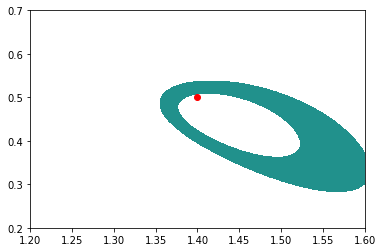

In [381]:
plt.contourf(np.exp(results-np.max(results)), extent=[np.min(mus), np.max(mus), np.min(sigmas), np.max(sigmas)], levels=credible_levels(np.exp(results-np.max(results)).flatten(), np.array([0.68, 0.95])))
plt.scatter(1.4, 0.5, c='r')

In [ ]:
pop = test.get_population(1000, False)
data = pop[:,:,0].squeeze()
data2 = pop[:,:,1].squeeze()
mus = np.linspace(1.2, 1.6)
sigmas = np.linspace(0.2, 0.7)
results = np.zeros((50,50))
for i in range(50):
    print(i)
    for j in range(50):
        results[i,j]=test.pop_like(pop, params=[mus[i], sigmas[j], 2]) #pop[:,:,0].squeeze()

[  1.           1.98104363   2.95841679 ... 145.38011032 145.38011032
 145.38011032]
[0.68 0.95]


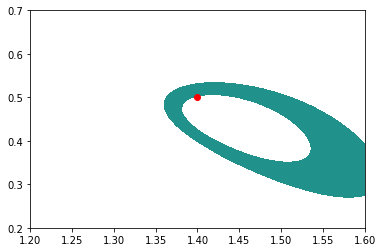

In [368]:
plt.contourf(np.exp(results-np.max(results)), extent=[np.min(mus), np.max(mus), np.min(sigmas), np.max(sigmas)], levels=credible_levels(np.exp(results-np.max(results)).flatten(), np.array([0.68, 0.95])))
plt.scatter(1.4, 0.5, c='r')

In [241]:
def credible_levels(ps, fs):
    """Find the probability levels that correspond to a given array of credible levels, e.g. to then pass into the levels argument of a contour plot
    Parameters:
       ps (1-d numpy array):
          the PDF values, a flattened array
       fs (1-d numpy array):
          the desired credible levels in ascending order, e.g. array([0.5,0.9]) for 50% and 90% credible levels
    """
    sorter = np.argsort(ps)
    ps_sorted = ps[sorter]
    ps_sorted = ps_sorted[::-1] #largest to smallest
    csum = np.cumsum(ps_sorted)
    print(csum)
    print(fs) 
    idxs = np.searchsorted(csum,fs*csum[-1])
    levels = ps_sorted[idxs]
    levels = levels[::-1]
    return levels

In [73]:
a, b = test.infer(pop, fixed={"m_TOV":2, "bh_min": 5, "bh_slope": 4, "max_jjkep": 1, "spin_slope": 1}, steps=1000)

 40%|████      | 401/1000 [00:44<01:12,  8.27it/s]/mnt/c/users/christine/gwcosmology/spin!!/populations.py:1020: RuntimeWarning: divide by zero encountered in log
  result = np.sum([np.log(self.event_likelihood_one_single(i, params)/mu) for i in samples])
100%|██████████| 1000/1000 [01:56<00:00,  8.57it/s]


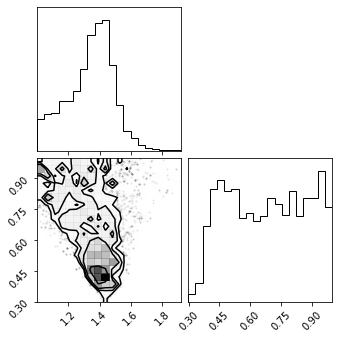

In [74]:
corner.corner(a[:,[0,1]]);

In [64]:
mus = np.linspace(1, 2)
sigmas = np.linspace(0.1, 1.0)
results = np.zeros((50,50))
for i in range(50):
    for j in range(50):
        results[i,j]=test.pop_like(pop, [mus[i], sigmas[j], 2, 5, 4, 1, 1])

In [75]:
mus = np.linspace(1, 2)
sigmas = np.linspace(0.1, 1.0)
results = np.zeros((50,50))
for i in range(50):
    for j in range(50):
        results[i,j]=test.pop_like(pop, [mus[i], sigmas[j], 2, 5, 4, 1, 1])

In [ ]:
def get_constraints_1c(counts, mTOV, hist=False, detector="APlus", folder = 'mTOV_convergence'):
    constraints = np.zeros((len(counts), 7))
    for i in range(len(counts)):
        run_name = '/{}_mTOV_{}_run_{}.txt'.format(detector, mTOV, counts[i])
        sigma_1 = get_quantiles(run_name, 2, [0.159, 0.841],hist=hist, folder=folder)
        sigma_2 = get_quantiles(run_name, 2, [0.025, 0.975], folder=folder)
        sigma_3 = get_quantiles(run_name, 2, [0.0015, 0.997], folder=folder)
        med = get_quantiles(run_name, 2, [0.5], folder=folder)
        constraints[i] = [sigma_3[0], sigma_2[0], sigma_1[0], med[0], sigma_1[1], sigma_2[1], sigma_3[1]]
    np.savetxt('../spin_results/outputs/{}/{}_mTOV_1C_{}.txt'.format(folder, detector, mTOV), constraints)
    return constraints

def get_constraints_lmg_2c(counts, mTOV, bhmin, hist=False, detector="APlus", folder = 'LMG_convergence'):
    constraints = np.zeros((len(counts), 7))
    for i in range(len(counts)):
        run_name = '/{}_mTOV_{}_bhmin_{}_{}.txt'.format(detector, mTOV,bhmin,  counts[i])
        sigma_1 = get_quantiles(run_name, 2, [0.159, 0.841],hist=hist, folder=folder, columns=[6,5])
        sigma_2 = get_quantiles(run_name, 2, [0.025, 0.975], folder=folder, columns=[6,5])
        sigma_3 = get_quantiles(run_name, 2, [0.0015, 0.997], folder=folder, columns=[6,5])
        med = get_quantiles(run_name, 2, [0.5], columns=[6,5], folder=folder)
        constraints[i] = [sigma_3[0], sigma_2[0], sigma_1[0], med[0], sigma_1[1], sigma_2[1], sigma_3[1]]
        if i == 4:
            print(run_name)
    np.savetxt('../spin_results/outputs/{}/{}_2c_{}_{}.txt'.format(folder, detector, mTOV, bhmin), constraints)
    return constraints

def get_constraints_lmg_u(counts, mTOV, bhmin, hist=False, detector="APlus", folder = 'LMG_convergence'):
    constraints = np.zeros((len(counts), 7))
    for i in range(len(counts)):
        run_name = '/{}_mTOV_{}_bhmin_{}_{}_u.txt'.format(detector, mTOV,bhmin,  counts[i])
        sigma_1 = get_quantiles(run_name, 2, [0.159, 0.841],hist=hist, folder=folder, columns=[3,2])
        sigma_2 = get_quantiles(run_name, 2, [0.025, 0.975], folder=folder, columns=[3,2])
        sigma_3 = get_quantiles(run_name, 2, [0.0015, 0.997], folder=folder, columns=[3,2])
        med = get_quantiles(run_name, 2, [0.5], columns=[3,2], folder=folder)
        constraints[i] = [sigma_3[0], sigma_2[0], sigma_1[0], med[0], sigma_1[1], sigma_2[1], sigma_3[1]]
        if i == 4:
            print(run_name)
    np.savetxt('../spin_results/outputs/{}/{}_u_{}_{}.txt'.format(folder, detector, mTOV, bhmin), constraints)
    return constraints

def get_constraints_slope_2c(counts, mTOV, hist=False, detector="APlus", folder = 'mTOV_convergence'):
    constraints = np.zeros((len(counts), 7))
    for i in range(len(counts)):
        run_name = '/{}_mTOV_{}_run_{}_2c_slope.txt'.format(detector, mTOV, counts[i])
        sigma_1 = get_quantiles(run_name, 8, [0.159, 0.841],hist=hist, folder=folder)
        sigma_2 = get_quantiles(run_name, 8, [0.025, 0.975], folder=folder)
        sigma_3 = get_quantiles(run_name, 8, [0.0015, 0.997], folder=folder)
        med = get_quantiles(run_name, 8, [0.5], folder=folder)
        constraints[i] = [sigma_3[0], sigma_2[0], sigma_1[0], med[0], sigma_1[1], sigma_2[1], sigma_3[1]]
    np.savetxt('../spin_results/outputs/{}/{}_mTOV_2C_slope_{}.txt'.format(folder, detector, mTOV), constraints)
    return constraints

def get_bias_2c(counts, mTOV, hist=False, detector="APlus", folder = 'mTOV_convergence'):
    constraints = np.zeros((len(counts), 7))
    for i in range(len(counts)):
        run_name = '/{}_mTOV_{}_run_{}_2c_bias.txt'.format(detector, mTOV, counts[i])
        sigma_1 = get_quantiles(run_name, 5, [0.159, 0.841],hist=hist, folder=folder)
        sigma_2 = get_quantiles(run_name, 5, [0.025, 0.975], folder=folder)
        sigma_3 = get_quantiles(run_name, 5, [0.0015, 0.997], folder=folder)
        med = get_quantiles(run_name, 5, [0.5], folder=folder)
        constraints[i] = [sigma_3[0], sigma_2[0], sigma_1[0], med[0], sigma_1[1], sigma_2[1], sigma_3[1]]
    np.savetxt('../spin_results/outputs/{}/{}_mTOV_bias_2C_{}.txt'.format(folder, detector, mTOV), constraints)
    return constraints

def get_constraints_2c(counts, mTOV, hist=False, detector="APlus", folder = 'mTOV_convergence'):
    constraints = np.zeros((len(counts), 7))
    for i in range(len(counts)):
        run_name = '/{}_mTOV_{}_run_{}_2component.txt'.format(detector, mTOV, counts[i])
        sigma_1 = get_quantiles(run_name, 5, [0.159, 0.841],hist=hist, folder=folder)
        sigma_2 = get_quantiles(run_name, 5, [0.025, 0.975], folder=folder)
        sigma_3 = get_quantiles(run_name, 5, [0.0015, 0.997], folder=folder)
        med = get_quantiles(run_name, 5, [0.5], folder=folder)
        constraints[i] = [sigma_3[0], sigma_2[0], sigma_1[0], med[0], sigma_1[1], sigma_2[1], sigma_3[1]]
    np.savetxt('../spin_results/outputs/{}/{}_mTOV_2C_{}.txt'.format(folder, detector, mTOV), constraints)
    return constraints

def get_constraints_u(counts, mTOV, hist=False, detector="APlus", folder = 'mTOV_convergence'):
    constraints = np.zeros((len(counts), 7))
    for i in range(len(counts)):
        run_name = '/{}_mTOV_{}_run_{}_uniform.txt'.format(detector, mTOV, counts[i])
        sigma_1 = get_quantiles(run_name, 2, [0.159, 0.841],hist=hist, folder=folder)
        sigma_2 = get_quantiles(run_name, 2, [0.025, 0.975], folder=folder)
        sigma_3 = get_quantiles(run_name, 2, [0.0015, 0.997], folder=folder)
        med = get_quantiles(run_name, 2, [0.5], folder=folder)
        constraints[i] = [sigma_3[0], sigma_2[0], sigma_1[0], med[0], sigma_1[1], sigma_2[1], sigma_3[1]]
    np.savetxt('../spin_results/outputs/{}/{}_mTOV_u_{}.txt'.format(folder, detector, mTOV), constraints)
    return constraints

def calc_convergence(file, counts=np.linspace(10,50,5,dtype='int16'), plot=True):
    constraints = np.genfromtxt(file)
    sig3 = constraints[:,-1]-constraints[:,0]
    sig2 = constraints[:,-2]-constraints[:,1]
    sig1 = constraints[:,-3]-constraints[:,2]
    if plot:
        plt.plot(counts, sig3, label='3$\sigma$')
        plt.plot(counts, sig2, label='2$\sigma$')
        plt.plot(counts, sig1, label='1$\sigma$')
        plt.yscale('log')
        plt.xscale('log')
    p = np.polyfit(x=np.log(counts), y=np.log(sig1), deg=1)
    print(p)

In [ ]:
import os
plt.ioff()
base = 'LMG_convergence_medspin'
folder = '../spin_results/{}/'.format(base)
combinations = [] #['2.0', '2.0']
for i in os.listdir(folder):
    # print(i)
    if 'likes' not in i and os.path.isfile(os.path.join(folder,i)) and "Design" in i:
        root = i.split('.txt')[0]
        
        mTOV = root.split('_')[2]
        bhmin = root.split('_')[4]
        if [mTOV, bhmin] not in combinations:
            print(root)
            combinations.append([mTOV, bhmin])
            
            if 'u' in root:
                constraints = get_constraints_lmg_u(np.linspace(10,50,5, dtype='int16'), mTOV, bhmin, detector='Design', folder=base)

            else:
                constraints = get_constraints_lmg_2c(np.linspace(10,50,5, dtype='int16'), mTOV, bhmin, detector='Design', folder=base)
        
            fig = plt.figure()
            plot_constraints(constraints, counts=np.linspace(10,50,5))
            plt.savefig('../spin_results/outputs/{}/{}.png'.format(base, root))
            plt.close(fig)